# Import Libraries

In [15]:
import collections
import functools
import hashlib
import inspect
import math
import numbers
import os
import random
import re
import shutil
import sys
import tarfile
import time
import zipfile
from collections import defaultdict
import pandas as pd
import requests
from IPython import display
from matplotlib import pyplot as plt

import numpy as np
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
import d2l
from datetime import datetime, timedelta, date

import seaborn as sns

dict = {"date":[],"frame":[]}


# Dataloader

Here we modified supplied d2l.py with KMNIST dataset:

In [16]:
#Workers to load dataset efficiently
def get_dataloader_workers():
    """Use 2 processes to read the data.

    Defined in :numref:`sec_K_mnist`"""
    return 2


In [17]:
#modified d2l function to download KMNIST
def load_data_Kmnist(batch_size, resize=None):
    """Download the K-MNIST dataset and then load it into memory.

    Defined in :numref:`sec_K_mnist`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.KMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.KMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))


# Stem

In [18]:
class Stem(torch.nn.Module):
    def __init__(self):
        super(Stem, self).__init__()
        # Here we are using torch.unfold library to divide input tensor images into smaller patches of size K*K
        # Here kernel_size is our patch sizer of 4*4 and stride is way to prevent overlap
        # unfold output = batch size (B) x total kernel size (k) x No of Patches (p)
        self.add_module('unfold',nn.Unfold(kernel_size=(4,4), stride=4)) 
        #number of patches obtained = (32*32 / 4*4)=64, which is input for batch normalisation. 32*32 is input tensor size
        self.add_module('batchnorm1', nn.BatchNorm1d(64)) 
        #mapping 4*4 patch features to 64 hidden layers
        self.add_module('linear',nn.Linear(16,64))
        #non linear activation function
        self.add_module('relu', nn.ReLU())
        
    def forward(self, x):
        out = x
        out = self._modules['unfold'](out)
        # uncomment print to check dimesions of unfold output
        # print("unfold shape = ",out.shape)
        # we use permute to transpose 
        out = out.permute(0,2,1)
        # out = B x p x k
        # print("unfold shape = ",out.shape)
        out = self._modules['batchnorm1'](out)
        out = self._modules['linear'](out)
        out = self._modules['relu'](out)
        # print("unfold shape = ",out.shape)
        
        return out

# BackBone

In [74]:
#BackBone Block
class BackBone(torch.nn.Module):
  def __init__(self,input_layers,num_patches, hidden_layers1, hidden_layers2):
    super(BackBone,self).__init__()
    # takes in defined number of patches and input layers
    self.input_layers = input_layers
    self.num_patches=num_patches
    
    #MLP1
    self.add_module('linear1',nn.Linear(num_patches,hidden_layers1))
    # we normalise the middle dimension after getting the transposed output from 1st Linear Layer
    self.add_module('batchnorm1', nn.BatchNorm1d(input_layers))
    self.add_module('relu1', nn.ReLU())
    self.add_module('linear2',nn.Linear(hidden_layers1,num_patches))
    
    
    #MLP2
    self.add_module('linear3',nn.Linear(input_layers,hidden_layers2))
    # again middle dimension is normalised after getting transposed output from 3rd linear layer
    self.add_module('batchnorm2', nn.BatchNorm1d(num_patches))
    self.add_module('relu2', nn.ReLU())
    self.add_module('linear4',nn.Linear(hidden_layers2,input_layers))
    

    self.add_module('relu3', nn.ReLU())

  def forward(self, x):
        
        out = x
        # print("backbone shape = ",out.shape)
        # uncomment above command to check output shape and transpose as required by the assignment
        # out = B x P x d here d is our input layers
        out = self._modules['linear1'](out.permute(0,2,1))
        # out = B x d x P
        out = self._modules['batchnorm1'](out)
        out = self._modules['relu1'](out)
        out = self._modules['linear2'](out)
        
        
        # print("backbone shape = ",out.shape)
        # uncomment above command to check output for the 
        # out = B x d x P
        out = self._modules['linear3'](out.permute(0,2,1))
        # out = B x p x D, same as original input before 1st MLP
        # batch normalisation layer can be commented out for experiment
        out = self._modules['batchnorm2'](out)
        out = self._modules['relu2'](out)
        out = self._modules['linear4'](out)
        

        # out = out+x
        # uncomment above command for residual connection, in our testing it didn't provide any meaningful advantage
        out = self._modules['relu3'](out)


        return out

# Network and Classifier

In [75]:
class DV_Net(torch.nn.Module):
    def __init__(self):
        super(DV_Net, self).__init__()
        # d is input layers
        self.no_d = 64
        self.num_patches = 64
        # calling stem
        self.add_module('Stem', Stem())
        # calling backbone blocks
        self.add_module('BackBone0', BackBone(self.no_d, self.num_patches, 64, 64))
        self.add_module('BackBone1', BackBone(self.no_d, self.num_patches, 128, 128))
        self.add_module('BackBone2', BackBone(self.no_d, self.num_patches, 256, 256))
        self.add_module('BackBone3', BackBone(self.no_d, self.num_patches, 512, 512))
        #optional 5 Backbone block, uncomment command below to include it in network
        # self.add_module('BackBone4', BackBone(self.no_d, self.num_patches, 1024, 1024))
        # classification layer with 10 outputs as we have 10 classes
        self.last = nn.Sequential(nn.Flatten(), nn.Linear(64*64, 10))
        
    def forward(self, x):
        
        out = x
        out = self._modules['Stem'](out)
        out = self._modules['BackBone0'](out)
        out = self._modules['BackBone1'](out)
        out = self._modules['BackBone2'](out)
        out = self._modules['BackBone3'](out)
        #optional 5th BackBone
        # out = self._modules['BackBone4'](out)
        out = self.last(out)

        return out

# Training 1 Sample/ Network Initialization

Re-Initialize Network here

In [76]:
# Network Initialisation
dvnet = DV_Net()

In [77]:
# We are using code from Labs to check if the network works by passing just 1 sample.
batch_size = 128
train_iter, test_iter = load_data_Kmnist(batch_size,resize = 32)
train2=iter(train_iter)
x = next(train2)
#print(x[0].size())
y_hat = dvnet(x[0])
num_epochs = 20


# Network

In [37]:
# Following prints the deplyed network and we can observe what's happening in each layer
DV_Net()

DV_Net(
  (Stem): Stem(
    (unfold): Unfold(kernel_size=(4, 4), dilation=1, padding=0, stride=4)
    (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear): Linear(in_features=16, out_features=64, bias=True)
    (relu): ReLU()
  )
  (BackBone0): BackBone(
    (linear1): Linear(in_features=64, out_features=64, bias=True)
    (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=64, out_features=64, bias=True)
    (linear3): Linear(in_features=64, out_features=64, bias=True)
    (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (linear4): Linear(in_features=64, out_features=64, bias=True)
    (relu3): ReLU()
  )
  (BackBone1): BackBone(
    (linear1): Linear(in_features=64, out_features=128, bias=True)
    (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, tra

# Training Function

In [12]:
# This code snippet is taken from the labs and modified to store data in a dataframe for every epoch
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device,df):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
        # this dictionary is used to store data on every epoch
        dict2 = {'Training Loss': train_loss, 'Training Accuracy': train_acc, 'Testing Accuracy': test_acc}
        df = df.append(dict2, ignore_index = True)
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    
    return df

# Model Training and Tuning

Reset Network Before running each model

# Final Model

In [78]:
# here we modify hyper parameters before training the model
lr, num_epochs, batch_size = 0.09, 20, 128
train_iter, test_iter = load_data_Kmnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dvnet.parameters(), lr=lr)

loss 0.011, train acc 0.996, test acc 0.934
8048.7 examples/sec on cuda:2


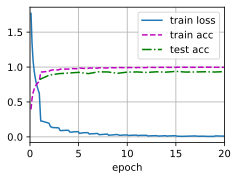

In [79]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
df = pd.DataFrame()
df =trainf(dvnet, train_iter, test_iter, loss, num_epochs, optimizer, device,df)

In [32]:
df.describe()

,Training Loss,Training Accuracy,Testing Accuracy
count,20.000000,20.000000,20.000000
mean,0.074282,0.975615,0.918130
std,0.131982,0.043804,0.023460
min,0.011407,0.798233,0.838000
25%,0.018540,0.979038,0.914850
50%,0.028848,0.990175,0.926450
75%,0.064590,0.993788,0.930975
max,0.605227,0.995983,0.940600


In [ ]:
df_final = df.copy()
df_final.to_csv('final.csv', sep='\t', encoding='utf-8')

# 0.05 Learning Rate Model

In [38]:
lr, num_epochs, batch_size = 0.05, 20, 128
train_iter, test_iter = load_data_Kmnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dvnet.parameters(), lr=lr)

loss 0.011, train acc 0.996, test acc 0.933
8106.0 examples/sec on cuda:2


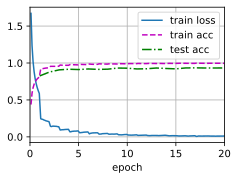

In [39]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
df = pd.DataFrame()
df =trainf(dvnet, train_iter, test_iter, loss, num_epochs, optimizer, device,df)

In [40]:
df.describe()

,Training Loss,Training Accuracy,Testing Accuracy
count,20.000000,20.000000,20.00000
mean,0.075708,0.975680,0.91671
std,0.127427,0.040718,0.02530
min,0.010356,0.815417,0.82510
25%,0.016792,0.977408,0.91515
50%,0.029897,0.990175,0.92150
75%,0.069984,0.994163,0.93220
max,0.574825,0.996617,0.93460


In [41]:
df_final = df.copy()
df_final.to_csv('0.05_LR.csv', sep='\t', encoding='utf-8')

# Batch Size 256 Model

In [44]:
lr, num_epochs, batch_size = 0.09, 20, 256
train_iter, test_iter = load_data_Kmnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dvnet.parameters(), lr=lr)

loss 0.007, train acc 0.998, test acc 0.928
11352.5 examples/sec on cuda:2


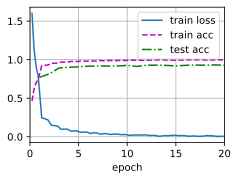

In [45]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
df = pd.DataFrame()
df =trainf(dvnet, train_iter, test_iter, loss, num_epochs, optimizer, device,df)

In [46]:
df.describe()

,Training Loss,Training Accuracy,Testing Accuracy
count,20.000000,20.000000,20.000000
mean,0.080961,0.973915,0.907375
std,0.157135,0.050783,0.040506
min,0.006904,0.769067,0.772500
25%,0.016050,0.978833,0.911450
50%,0.027119,0.991017,0.919200
75%,0.066220,0.994796,0.928100
max,0.712067,0.997583,0.932200


In [47]:
df_final = df.copy()
df_final.to_csv('256_batch.csv', sep='\t', encoding='utf-8')

# 5 Backbone Blocks Model

Uncomment 5th Backbone in DVnet before running this model

In [51]:
lr, num_epochs, batch_size = 0.09, 20, 128
train_iter, test_iter = load_data_Kmnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dvnet.parameters(), lr=lr)

loss 0.017, train acc 0.994, test acc 0.930
7437.3 examples/sec on cuda:2


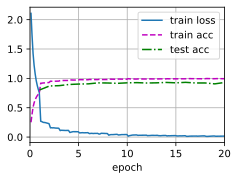

In [52]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
df = pd.DataFrame()
df =trainf(dvnet, train_iter, test_iter, loss, num_epochs, optimizer, device,df)

In [53]:
df.describe()

,Training Loss,Training Accuracy,Testing Accuracy
count,20.000000,20.000000,20.000000
mean,0.092786,0.969739,0.908885
std,0.161750,0.053435,0.030116
min,0.016999,0.753433,0.803700
25%,0.024455,0.974879,0.905625
50%,0.039806,0.986708,0.921400
75%,0.078364,0.991696,0.923950
max,0.742154,0.994167,0.932300


In [54]:
df_final = df.copy()
df_final.to_csv('5_layer.csv', sep='\t', encoding='utf-8')

# No Batch Normalisation in Backbone

In [70]:
lr, num_epochs, batch_size = 0.09, 20, 128
train_iter, test_iter = load_data_Kmnist(batch_size, resize=32)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(dvnet.parameters(), lr=lr)

loss 0.021, train acc 0.993, test acc 0.922
8424.2 examples/sec on cuda:2


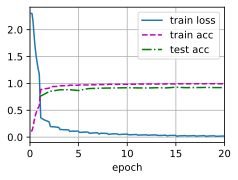

In [71]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
df = pd.DataFrame()
df =trainf(dvnet, train_iter, test_iter, loss, num_epochs, optimizer, device,df)

In [72]:
df.describe()

,Training Loss,Training Accuracy,Testing Accuracy
count,20.000000,20.000000,20.000000
mean,0.126728,0.957510,0.899965
std,0.246907,0.087568,0.040105
min,0.021060,0.595267,0.755300
25%,0.031449,0.968958,0.897900
50%,0.051949,0.982758,0.916150
75%,0.098445,0.989846,0.920650
max,1.139167,0.992567,0.928500


In [73]:
df_final = df.copy()
df_final.to_csv('no_batch_last.csv', sep='\t', encoding='utf-8')

# Evaluation & Analysis

Read all the csv files generated

In [80]:
df1 = pd.read_csv('final.csv',delimiter = '\t')
# 
# print(df1)
df2 = pd.read_csv('0.05_LR.csv',delimiter = '\t')
# df2 = df2.drop('Unnamed: 0',axis = 1)
# print(df2)
df3 = pd.read_csv('256_batch.csv',delimiter = '\t')
# df3 = df3.drop('Unnamed: 0',axis = 1)
# print(df3)
df4 = pd.read_csv('5_layer.csv',delimiter = '\t')
# df4 = df4.drop('Unnamed: 0',axis = 1)
# print(df4)
df5 = pd.read_csv('no_batch_last.csv',delimiter = '\t')
# df5 = df5.drop('Unnamed: 0',axis = 1)
# print(df5)

Generate Plots for Final Model

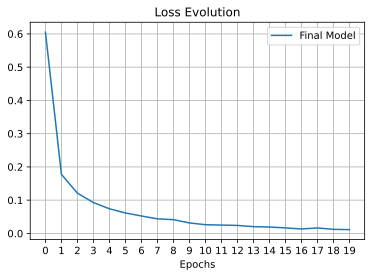

In [90]:
plt.xticks(range(0, 20))
plt.plot(df1["Unnamed: 0"], df1["Training Loss"], label = "Final Model")
plt.xlabel('Epochs')
plt.title('Loss Evolution')
plt.grid()
plt.legend()

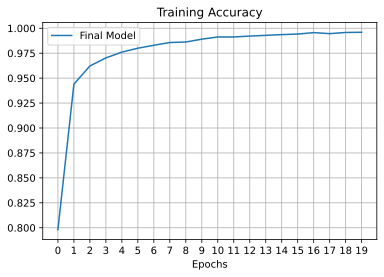

In [91]:
plt.xticks(range(0, 20))
plt.plot(df1["Unnamed: 0"], df1["Training Accuracy"], label = "Final Model")
plt.xlabel('Epochs')
plt.title('Training Accuracy')
plt.grid()
plt.legend()

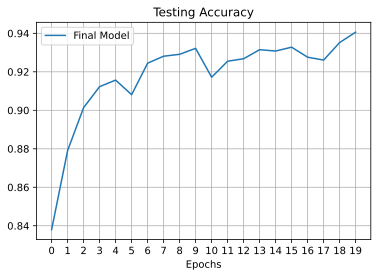

In [92]:
plt.xticks(range(0, 20))
plt.plot(df1["Unnamed: 0"], df1["Testing Accuracy"], label = "Final Model")
plt.xlabel('Epochs')
plt.title('Testing Accuracy')
plt.grid()
plt.legend()

Loss Evolution Comparison

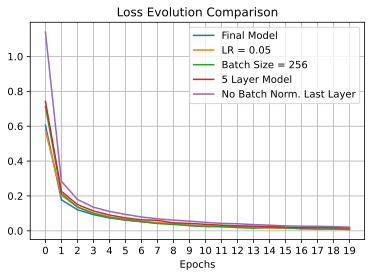

In [85]:
plt.xticks(range(0, 20))

plt.plot(df1["Unnamed: 0"], df1["Training Loss"], label = "Final Model")
plt.plot(df1["Unnamed: 0"],df2["Training Loss"], label = "LR = 0.05")
plt.plot(df1["Unnamed: 0"],df3["Training Loss"], label = "Batch Size = 256")
plt.plot(df1["Unnamed: 0"],df4["Training Loss"], label = "5 Layer Model")
plt.plot(df1["Unnamed: 0"],df5["Training Loss"], label = "No Batch Norm. Last Layer")
plt.xlabel('Epochs')
plt.title('Loss Evolution Comparison')
plt.grid()
plt.legend()


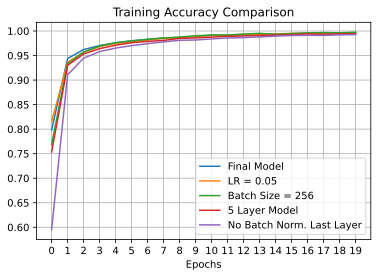

In [87]:
plt.xticks(range(0, 20))

plt.plot(df1["Unnamed: 0"], df1["Training Accuracy"], label = "Final Model")
plt.plot(df1["Unnamed: 0"],df2["Training Accuracy"], label = "LR = 0.05")
plt.plot(df1["Unnamed: 0"],df3["Training Accuracy"], label = "Batch Size = 256")
plt.plot(df1["Unnamed: 0"],df4["Training Accuracy"], label = "5 Layer Model")
plt.plot(df1["Unnamed: 0"],df5["Training Accuracy"], label = "No Batch Norm. Last Layer")
plt.grid()
plt.xlabel('Epochs')
plt.title('Training Accuracy Comparison')
plt.legend()

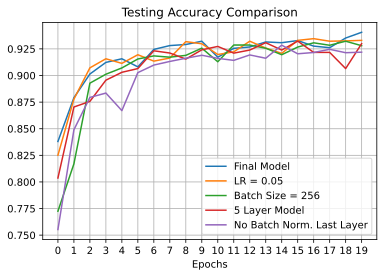

In [88]:
plt.xticks(range(0, 20))

plt.plot(df1["Unnamed: 0"], df1["Testing Accuracy"], label = "Final Model")
plt.plot(df1["Unnamed: 0"],df2["Testing Accuracy"], label = "LR = 0.05")
plt.plot(df1["Unnamed: 0"],df3["Testing Accuracy"], label = "Batch Size = 256")
plt.plot(df1["Unnamed: 0"],df4["Testing Accuracy"], label = "5 Layer Model")
plt.plot(df1["Unnamed: 0"],df5["Testing Accuracy"], label = "No Batch Norm. Last Layer")
plt.grid()
plt.xlabel('Epochs')
plt.title('Testing Accuracy Comparison')
plt.legend()